# Evaluation of models
This notebook will evaluate the models we've trained on the test set and compare their results with F1 score, confusion matricies, and other evaluations. We hope to help determine which model is best and compare and contrast performance.

The process will be to 
- load models
- load test set
- run inference
- evaluation metrics

## 0 Imports

In [49]:
import os
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
from src.data.make_dataset import convert_examples_to_bag_of_words

[nltk_data] Downloading package punkt to /home/denny/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [80]:
# import evaluation metrics
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score, \
precision_score, precision_recall_curve, recall_score

In [3]:
os.chdir('..')
os.getcwd()

'/home/denny/Documents/mids/w266_NLP/lit-shazam'

In [3]:
# Load preprocessed data

## 1 Load models

In [99]:

with open('./models/nb_model_full_corpus.pkl', 'rb') as f:
    nbf_model = pickle.load(f)
    
with open('./models/lr_model_full_corpus.pkl', 'rb') as f:
    lrf_model = pickle.load(f)
    
nbf_model.classes_
lrf_model.classes_

array([0, 1, 2, 3, 4, 5, 6])

## 2 Load test data

In [50]:
test_df = pd.read_parquet('./data/processed/test_case13.parquet')
test_df.head()

,Test Data,Test Label
0,He went out of the room looking back at the t...,1
1,Pooh. They don’t think much of such as that ov...,2
2,He entered the room with a look of self-conse...,4
3,"“She sot down,” said Joe, “and she got up, and...",3
4,Gazing out at the bleak expanse of tents exten...,0


In [51]:
test_examples = list(test_df['Test Data'])

In [52]:
convert_examples_to_bag_of_words(list(test_df['Test Data'])[:2])

['he went out of the room look back at the two men at the tabl what s the matter manolo zurito set down hi glass would you pic two bull for me to morrow night manuel ask look up at zurito across the tabl',
 'pooh they don t think much of such as that over there lot of em do it well if you take it like that i shall go back to him']

In [53]:
# process the same as baseline models
# 0. convert data, labels to list
# 1. tokenize
# 2. stem

test_processed_examples = convert_examples_to_bag_of_words(test_examples)
test_labels = list(test_df['Test Label'])

In [54]:
print('Number of test examples: ', len(test_processed_examples))
len(test_processed_examples) == len(test_labels)

Number of test examples:  6846


True

## 3 Run Inference

In [55]:
y_nbf = nbf_model.predict(test_processed_examples)
y_nbf[0:5]

array([1, 2, 4, 3, 0])

In [106]:
y_lrf = lrf_model.predict(test_processed_examples)
y_lrf_pred_probs = lrf_model.predict_proba(test_processed_examples)
y_lrf[0:5]

array([1, 2, 4, 3, 0])

In [56]:
test_labels[0:5]

[1, 2, 4, 3, 0]

# 4 Evaluation

In [57]:
conf_matrix = confusion_matrix(test_labels, y_nbf)
conf_matrix

array([[ 951,   18,   34,   37,   16,    9,    1],
       [  15,  555,   10,   16,   10,    6,    0],
       [   5,    4, 1138,   34,   32,    8,    1],
       [   6,    4,   19, 1785,   46,   19,    0],
       [   0,    0,    2,   18,  952,    2,    0],
       [   5,    2,    7,   32,   10,  616,    1],
       [   4,    1,    3,   11,    4,    2,  395]])

In [101]:
confusion_matrix(test_labels, y_lrf)

array([[1017,    9,   13,   14,    4,    8,    1],
       [  17,  584,    1,   10,    0,    0,    0],
       [  11,    3, 1164,   32,    5,    6,    1],
       [  15,    4,   17, 1819,   15,    8,    1],
       [   3,    0,    5,   28,  937,    1,    0],
       [  12,    1,    7,   15,    4,  634,    0],
       [   2,    1,    2,    2,    0,    1,  412]])

In [84]:
y_preb_probs = nbf_model.predict_proba(test_processed_examples)

In [81]:
y_test = test_labels
y_true = test_labels
y_pred = y_nbf

In [88]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_preb_probs, average="weighted", multi_class="ovr")

0.9958663505455118

In [89]:
class_labels = ["Fitzgerald", "Hemingway", "Dickens", "Hardy", "Austen", "Chesterton", "Shakespeare"]
print(classification_report(y_test, y_pred, target_names=class_labels))

              precision    recall  f1-score   support

  Fitzgerald       0.96      0.89      0.93      1066
   Hemingway       0.95      0.91      0.93       612
     Dickens       0.94      0.93      0.93      1222
       Hardy       0.92      0.95      0.94      1879
      Austen       0.89      0.98      0.93       974
  Chesterton       0.93      0.92      0.92       673
 Shakespeare       0.99      0.94      0.97       420

    accuracy                           0.93      6846
   macro avg       0.94      0.93      0.94      6846
weighted avg       0.93      0.93      0.93      6846



roc auc score: 0.996
              precision    recall  f1-score   support

  Fitzgerald       0.96      0.89      0.93      1066
   Hemingway       0.95      0.91      0.93       612
     Dickens       0.94      0.93      0.93      1222
       Hardy       0.92      0.95      0.94      1879
      Austen       0.89      0.98      0.93       974
  Chesterton       0.93      0.92      0.92       673
 Shakespeare       0.99      0.94      0.97       420

    accuracy                           0.93      6846
   macro avg       0.94      0.93      0.94      6846
weighted avg       0.93      0.93      0.93      6846

------------------------------------------------------------



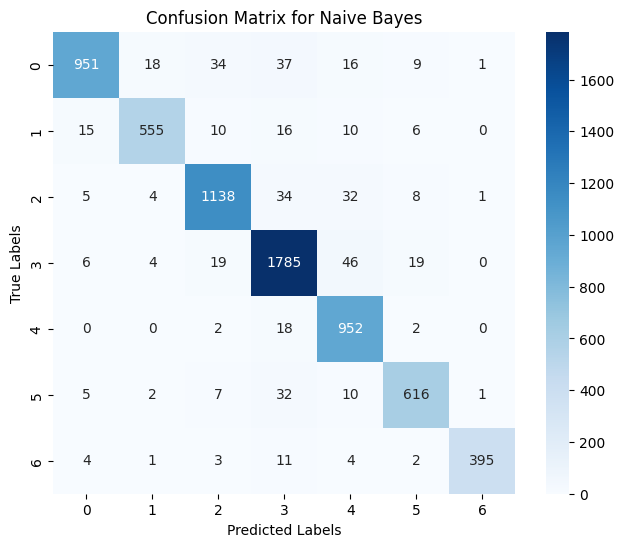

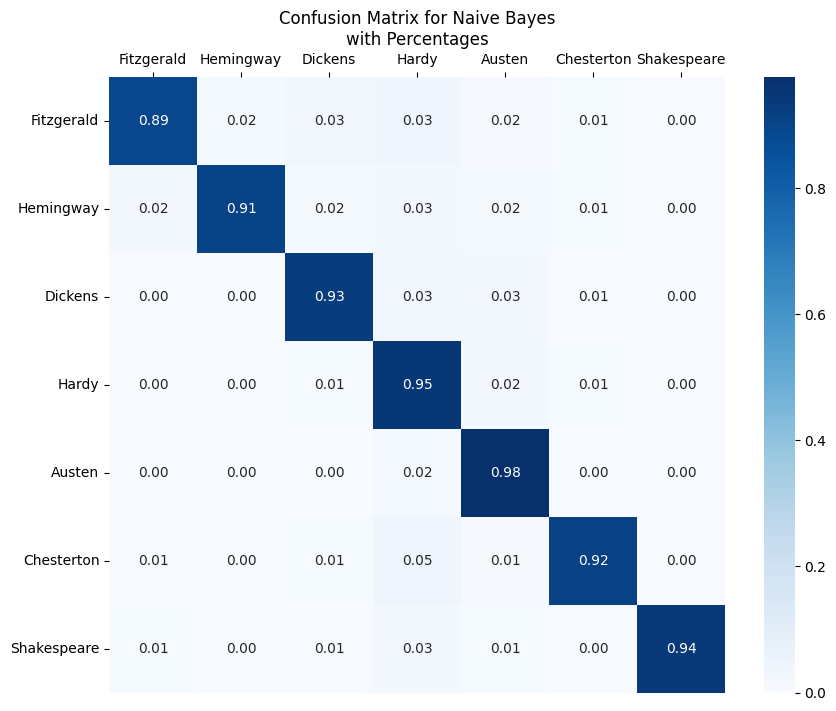

In [125]:
def eval_model(model_name, y_true, y_pred, y_pred_probas, conf_matrix):
    """perform standardized model evaluation
    prints metrics and plots to determine classification performance 
    TODO: returns a dictionary/dataframe of the metrics"""
    
    # TODO: change to load from dictionary
    class_labels = ["Fitzgerald", "Hemingway", "Dickens", "Hardy", "Austen", "Chesterton", "Shakespeare"]

    # print classification report
#     print('roc auc score: %0.3f' % roc_auc_score(y_test, y_preb_probs, average="weighted", multi_class="ovr"))
    print(classification_report(y_test, y_pred, target_names=class_labels))
    print("-" * 60)
    print()

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", square=True)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

    conf_matrix_percentage = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_percentage, annot=True, fmt=".2f", cmap="Blues", square=True, xticklabels=True, yticklabels=True)
    # Set row labels
    
    plt.yticks(np.arange(len(class_labels)) + 0.5, class_labels, rotation=0)
    plt.xticks(np.arange(len(class_labels)) + 0.5, class_labels, rotation=0)
    ax = plt.gca()
    ax.xaxis.set_ticks_position("top")

    # Add a title
    plt.title(f"Confusion Matrix for {model_name}\nwith Percentages")
    plt.show()    
    
    # return metrics
    precision = precision_score(y_test, y_pred, average="micro" )
    recall = recall_score(y_test, y_pred, average="micro")
    f1 = f1_score(y_test, y_pred, average="micro") # same as accuracy
#     accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_preb_probs, average="micro", multi_class="ovr")
#     ----------------------------------
#     model_name | f1 score | precision | recall | roc_auc
    metrics_df = pd.DataFrame(data={'f1_score':f1, 
                               'precision':precision, 'recall':recall, 'roc_auc':roc_auc},
                             index=[model_name])
    return metrics_df

nb_metrics = eval_model('Naive Bayes', y_true, y_pred, y_preb_probs, conf_matrix)

roc auc score: 0.996
              precision    recall  f1-score   support

  Fitzgerald       0.94      0.95      0.95      1066
   Hemingway       0.97      0.95      0.96       612
     Dickens       0.96      0.95      0.96      1222
       Hardy       0.95      0.97      0.96      1879
      Austen       0.97      0.96      0.97       974
  Chesterton       0.96      0.94      0.95       673
 Shakespeare       0.99      0.98      0.99       420

    accuracy                           0.96      6846
   macro avg       0.96      0.96      0.96      6846
weighted avg       0.96      0.96      0.96      6846

------------------------------------------------------------



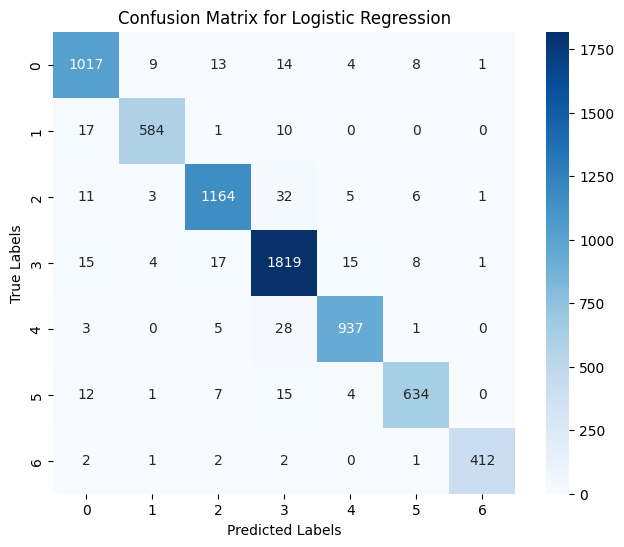

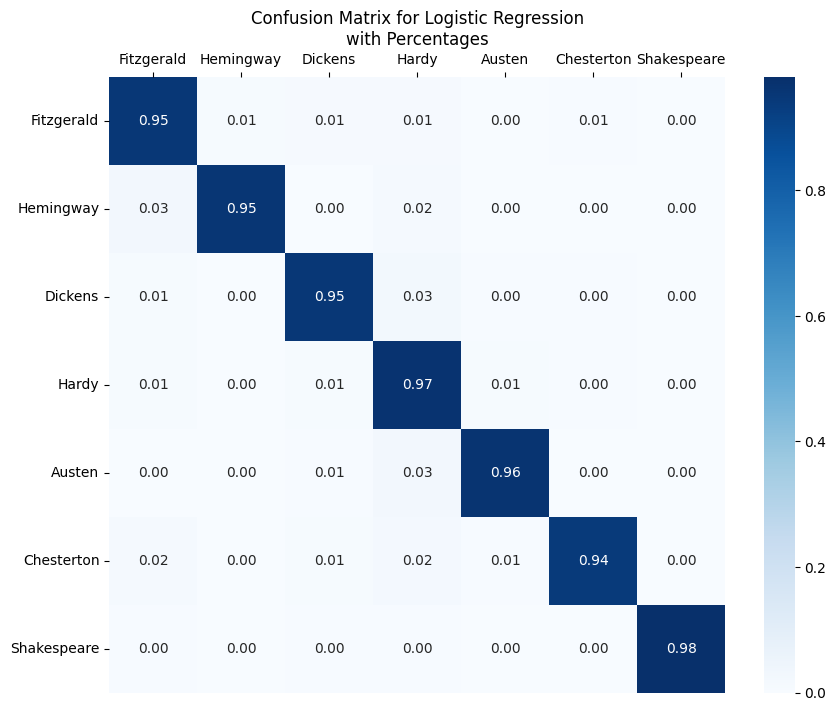

In [126]:
lr_metrics = eval_model('Logistic Regression', y_true, y_lrf, y_lrf_pred_probs, confusion_matrix(test_labels, y_lrf))

In [128]:
# example of comparison
pd.concat([nb_metrics,lr_metrics])

,f1_score,precision,recall,roc_auc
Naive Bayes,0.933684,0.933684,0.933684,0.996168
Logistic Regression,0.959246,0.959246,0.959246,0.996168


## Save evaluation metrics for comparison

In [13]:
# import pickle
# with open('./models/lr_model_full_corpus.pkl', 'wb') as f:
#     pickle.dump(logistic_pipeline, f)